In [128]:
# pip install Levenshtein

In [129]:
import pandas as pd
import numpy as np
from Levenshtein import distance
import geopandas as gpd
import json
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [130]:
def extract_names_from_geojson(geojson_file):
    with open(geojson_file, 'r') as file:
        data = json.load(file)
        names = []
        if data['type'] == 'FeatureCollection':
            for feature in data['features']:
                if 'name' in feature['properties']:
                    names.append(feature['properties']['name'])
        elif data['type'] == 'Feature':
            if 'name' in data['properties']:
                names.append(data['properties']['name'])
        return names

In [131]:
transfers = pd.read_csv('/content/drive/MyDrive/480-497-Demographic TIF Team/Transfers/DataFolder/Yates_Data/Master_TIF_formatted.csv')
demog = pd.read_csv('/content/drive/MyDrive/480-497-Demographic TIF Team/Demographic/TIF_population.csv')
bounds = gpd.read_file('/content/drive/MyDrive/480-497-Demographic TIF Team/Transfers/DataFolder/Boundaries - Tax Increment Financing Districts.geojson')

In [132]:
transfers = transfers.replace("ArcherWestern","Archer/Western")

In [133]:
transfers

,Unnamed: 0,tif_name,tif_year,property_tax_extraction,transfers_in,transfers_out,cumulative_transfers_in,cumulative_transfers_out,cumulative_property_tax_extraction
0,0,105th Street and Vincennes Avenue,2014,133001,353381,0,353381,0,133001
1,1,105th Street and Vincennes Avenue,2015,648627,353381,0,706762,0,781628
2,2,105th Street and Vincennes Avenue,2016,768234,0,0,706762,0,1549862
3,3,105th Street and Vincennes Avenue,2017,1190748,0,0,706762,0,2740610
4,4,105th Street and Vincennes Avenue,2018,1038646,706761,0,1413523,0,3779256
...,...,...,...,...,...,...,...,...,...
1272,1272,Woodlawn,2018,3544196,0,1850624,0,7949132,14475204
1273,1273,Woodlawn,2019,3660943,0,5800000,0,13749132,18136147
1274,1274,Woodlawn,2020,4203405,0,0,0,13749132,22339552
1275,1275,Woodlawn,2021,4922348,0,0,0,13749132,27261900


# Handling missing TIFs

In [134]:
missing_tifs = []
for tif in transfers['tif_name'].unique():
  if tif not in demog['TIF-bound'].unique():
    missing_tifs.append(tif)
missing_tifs

['126th/Torrence',
 '134th/Avenue K',
 '35th/Wallace',
 '41st/King',
 '45th/Western',
 '49th/St. Lawrence',
 '60th/Western',
 '69th/Ashland',
 '95th/Stony Island',
 'Addison North',
 'Archer Courts',
 'Calumet River',
 'Calumet/Cermak',
 'Chicago Lakeside Development - Phase 1',
 'Clark/Ridge',
 'Devon/Western',
 'Drexel Boulevard',
 'Harlem industrial Park Conservation Area',
 'Harlem Industrial Park Conservation Area',
 'Irving Park/Elston',
 'Irving/Cicero',
 'Jefferson Park',
 'Kostner Avenue',
 'LaSalleCentral',
 'Lincoln/Belmont/Ashland',
 'Montclare',
 'Near South',
 'North Branch North',
 'North Branch South',
 'North/Cicero',
 'Pershing/King',
 'Peterson/Cicero',
 'Portage Park',
 'Ravenswood Corridor',
 'Read/Dunning',
 'River South',
 'Roosevelt/Canal',
 'Roosevelt/Homan',
 'Roosevelt/Union',
 'South Works Industrial',
 'Stockyards Annex',
 'Stony Island Commercial/Burnside Industrial',
 'Weed/Fremont',
 'West Pullman']

In [135]:
def get_match(str1:str, values:list[str]):
    closest_distance = float('inf')
    closest_value = None
    for value2 in values:
        if value2 == "SBIF":
            continue
        if ((False not in [word.lower() in value2.lower() for word in str1.split(' ')]) or
            (False not in [word.lower() in str1.lower() for word in value2.split(' ')])):
            return value2
        dist = distance(str1.lower(), value2.lower())
        if dist < closest_distance:
            closest_distance = dist
            closest_value = value2
    return closest_value

def find_closest_match(list1:list[str], list2:list[str], limbo=False):
    limbo = []

    # Find closest match for each element in col1
    closest_mapping = {}
    closest_mapping_swapped = {None: []}

    for TIF in list1:
        closest_value = get_match(TIF, list2)

        if (limbo):
            if (closest_value in closest_mapping_swapped):
                limbo.append((TIF, []))

            while (limbo):
                new_key = limbo[0][0]
                tries = limbo[0][1]
                value = get_match(TIF, [x for x in list1 if x not in tries])
                set_key = closest_mapping_swapped[value] if value in closest_mapping_swapped else None

                if not value:
                    closest_mapping[new_key] = value
                    closest_mapping_swapped[value].append(new_key)
                    limbo.pop()
                elif (set_key == None):
                    closest_mapping[new_key] = value
                    closest_mapping_swapped[value] = new_key
                    limbo.pop()
                elif (distance(set_key, value) > distance(new_key, value)):
                    del closest_mapping[set_key]
                    del closest_mapping_swapped[value]
                    closest_mapping[new_key] = value
                    closest_mapping_swapped[value] = new_key
                    limbo.pop()
                    limbo.append((set_key, []))
                else:
                    limbo[0][1].append(value)

        closest_mapping[TIF] = closest_value
        closest_mapping_swapped[closest_value] = TIF

    new_df = pd.DataFrame([(k,v, distance(k,v), 1-distance(k,v)/len(v)) for k,v in closest_mapping.items()], columns = (["1", "2", "distance", "accuracy"]))

    return new_df, closest_mapping_swapped[None]

In [136]:
matches, nones = find_closest_match(missing_tifs, list(demog["TIF-bound"].unique()), False)

In [137]:
matches = matches[matches['1'].isin(['LaSalleCentral'])]
missing_tifs.remove('LaSalleCentral')

In [138]:
matches

,1,2,distance,accuracy
23,LaSalleCentral,LaSalle Central,1,0.933333


In [139]:
conversions = {row["1"]:row["2"] for index, row in matches.iterrows()}
demog["TIF-bound"] = demog["TIF-bound"].replace(conversions)
demog['TIF-bound'].unique()

array(['105th Street and Vincennes Avenue', '107th/Halsted',
       '111th Street/Kedzie Avenue Business District', '116th/Avenue O',
       '119th Street/I-57', '119th and Halsted', '24th/Michigan',
       '26th & King Drive', '35th/Halsted', '35th/State',
       '43rd Street/Cottage Grove Avenue', '47th and King Drive',
       '47th/Ashland', '47th/Halsted', '47th/State', '51st and Lake Park',
       '51st/Archer', '53rd Street', '63rd/Ashland', '63rd/Pulaski',
       '67th and Wentworth', '67th/Cicero', '71st & Stony Island',
       '73rd/University', '79th Street Corridor',
       '79th Street/Southwest Highway', '79th and Cicero',
       '79th/Vincennes', '83rd/Stewart', '87th/Cottage Grove',
       '95th & Western', 'Addison South', 'Archer/Central',
       'Archer/Western', 'Armitage/Pulaski', 'Austin Commercial',
       'Avalon Park/South Shore', 'Avondale', 'Belmont/Central',
       'Belmont/Cicero', 'Bronzeville', 'Bryn Mawr/Broadway',
       'Canal/Congress', 'Central West',

In [140]:
print("Rows before: ",len(transfers))
for tif in missing_tifs:
  transfers = transfers[transfers['tif_name'] != tif]
print("Rows after: ",len(transfers))

Rows before:  1277
Rows after:  1041


Data Prep for Model Training

In [141]:
transfers['transferred'] = transfers['transfers_in'] - transfers['transfers_out']

In [142]:
demog = demog.rename(columns={"TIF-bound":"tif_name"})

In [143]:
data = pd.merge(transfers, demog, on='tif_name')

In [144]:
data.head(10)

,Unnamed: 0,tif_name,tif_year,property_tax_extraction,transfers_in,transfers_out,cumulative_transfers_in,cumulative_transfers_out,cumulative_property_tax_extraction,transferred,Hispanic Demographic Population,White Demographic Population,Black Demographic Population,Asian Demographic Population,Total Population,Majority Demographic
0,0,105th Street and Vincennes Avenue,2014,133001,353381,0,353381,0,133001,353381,103.168689,318.306674,10503.113421,6.146657,11057.900850,Black Demographic Population
1,1,105th Street and Vincennes Avenue,2015,648627,353381,0,706762,0,781628,353381,103.168689,318.306674,10503.113421,6.146657,11057.900850,Black Demographic Population
2,2,105th Street and Vincennes Avenue,2016,768234,0,0,706762,0,1549862,0,103.168689,318.306674,10503.113421,6.146657,11057.900850,Black Demographic Population
3,3,105th Street and Vincennes Avenue,2017,1190748,0,0,706762,0,2740610,0,103.168689,318.306674,10503.113421,6.146657,11057.900850,Black Demographic Population
4,4,105th Street and Vincennes Avenue,2018,1038646,706761,0,1413523,0,3779256,706761,103.168689,318.306674,10503.113421,6.146657,11057.900850,Black Demographic Population
5,5,105th Street and Vincennes Avenue,2019,778591,0,0,1413523,0,4557847,0,103.168689,318.306674,10503.113421,6.146657,11057.900850,Black Demographic Population
6,6,105th Street and Vincennes Avenue,2020,759998,0,0,1413523,0,5317845,0,103.168689,318.306674,10503.113421,6.146657,11057.900850,Black Demographic Population
7,7,105th Street and Vincennes Avenue,2021,1311739,0,0,1413523,0,6629584,0,103.168689,318.306674,10503.113421,6.146657,11057.900850,Black Demographic Population
8,8,105th Street and Vincennes Avenue,2022,1383445,0,0,1413523,0,8013029,0,103.168689,318.306674,10503.113421,6.146657,11057.900850,Black Demographic Population
9,9,107th/Halsted,2014,0,0,0,0,0,0,0,326.368206,277.956232,9949.942659,10.419526,10688.371751,Black Demographic Population


In [145]:
data.columns

Index(['Unnamed: 0', 'tif_name', 'tif_year', 'property_tax_extraction',
       'transfers_in', 'transfers_out', 'cumulative_transfers_in',
       'cumulative_transfers_out', 'cumulative_property_tax_extraction',
       'transferred', 'Hispanic Demographic Population',
       'White Demographic Population', 'Black Demographic Population',
       'Asian Demographic Population', 'Total Population',
       'Majority Demographic'],
      dtype='object')

In [146]:
bounds.rename(columns={"name":"tif_name"}, inplace=True)

In [147]:
missing_tifs = []
for tif in bounds["tif_name"]:
  if tif not in data['tif_name'].unique():
    missing_tifs.append(tif)
missing_tifs

['Stony Island Avenue Commercial and Burnside Industrial Corridors']

In [148]:
matches, nones = find_closest_match(missing_tifs, data['tif_name'], False)

In [149]:
matches

,1,2,distance,accuracy
0,Stony Island Avenue Commercial and Burnside In...,Commercial Avenue,50,-1.941176


In [150]:
[x for x in data['tif_name'].unique() if 'stony' in x.lower()]

['71st & Stony Island']

In [151]:
data = data[data['tif_name'] != 'Stony Island Avenue Commercial and Burnside Industrial Corridors']

# Predicting Amount transferred from the demographic makeup of a TIF

In [152]:
predictors = ['Hispanic Demographic Population',
       'White Demographic Population', 'Black Demographic Population',
       'Asian Demographic Population']
target = 'transferred'

In [153]:
# Define a function to remove outliers based on Z-score
def remove_outliers(df, predictors, threshold=3):
    preds = df[predictors]
    # Calculate Z-score for each value in the DataFrame
    z_scores = np.abs((preds - preds.mean()) / preds.std())

    # Identify rows where the absolute Z-score is greater than the threshold
    outlier_rows = z_scores.apply(lambda x: (x > threshold).any(), axis=1)

    # Remove outlier rows from the DataFrame
    df_cleaned = df[~outlier_rows]

    return df_cleaned

In [154]:
data_linear = data.copy()

data_linear = remove_outliers(data_linear, predictors)

In [155]:
print(len(data))
print(len(data_linear))

1040
1005


In [156]:
X_train, X_test, y_train, y_test = train_test_split(data_linear[predictors], data_linear[target], test_size=0.2, random_state=42)

In [157]:
model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 18990423612549.88


In [158]:
coefficients = model.coef_
intercept = model.intercept_
print(coefficients)
print(intercept)

[ -52.70826522 -399.15981639   13.14858047  591.33222032]
676102.9896189014


268237.01033458556
676006.2098115841


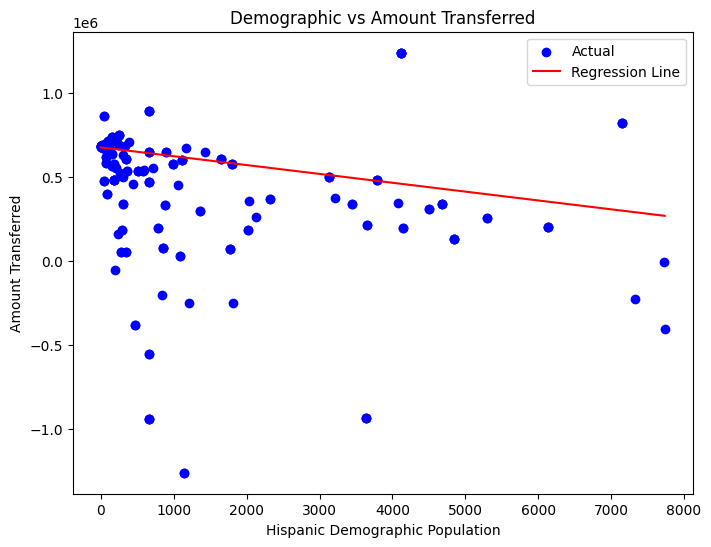

-2106539.3571398454
674198.2065427799


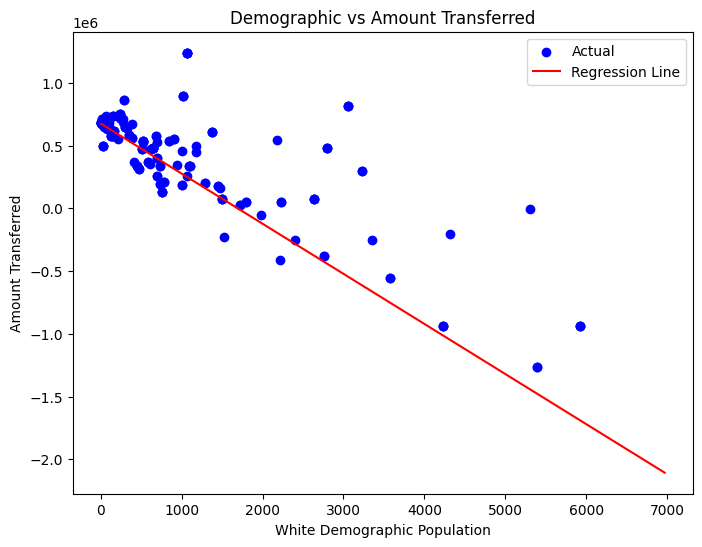

676173.2739244774
844085.9692704186


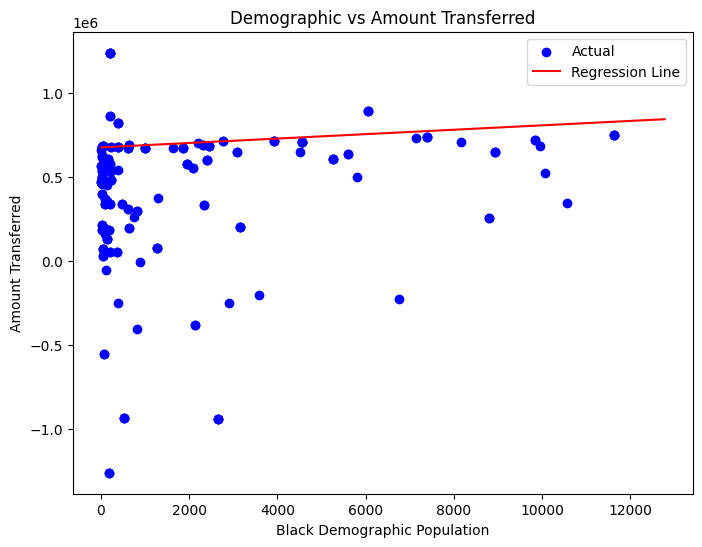

676102.9896189014
2505231.883135114


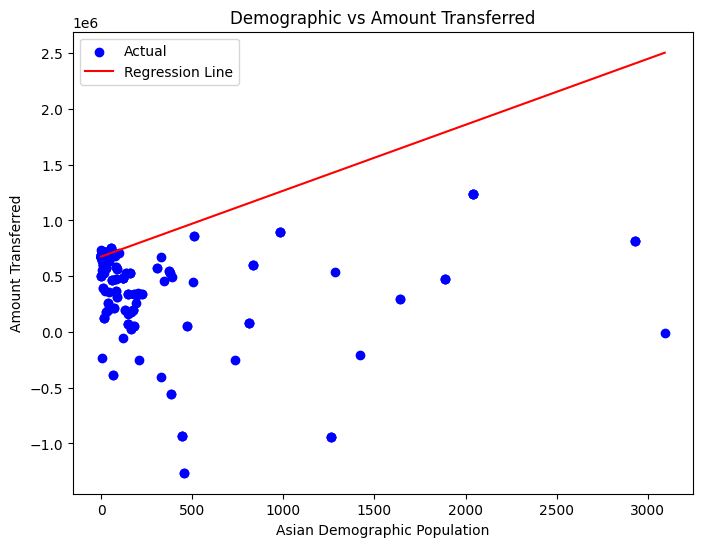

In [159]:
# Assuming your linear regression model is named 'model' and you have already fitted it to your training data
for i in range(len(predictors)):
  predictor = predictors[i]
  slope = coefficients[i]
  # Make predictions on the training data
  x_values = np.linspace(min(X_train[predictor]), max(X_train[predictor]), 100)
  y_values = slope * x_values + intercept

  print(min(y_values))
  print(max(y_values))

  # Create scatter plot
  plt.figure(figsize=(8, 6))
  # sns.scatterplot(x=X_test[predictor], y=y_pred, label='Actual', color='blue')
  plt.scatter(x=X_test[predictor], y=y_pred, color='blue',label='Actual')
  # hb = plt.hexbin(X_test[predictor], y_pred, gridsize=20, cmap='inferno', label='Actual')
  # plt.colorbar(hb)
  plt.plot(x_values, y_values, color='red', label='Regression Line')

  # Set labels and title
  plt.xlabel(predictor)
  plt.ylabel('Amount Transferred')
  plt.title('Demographic vs Amount Transferred')

  # Show plot
  plt.legend()
  plt.show()


# Predicting Fact of Transfer (1,0,-1) from the demographic makeup of a TIF

In [160]:
data_log = data.copy()
data_log['fact_of_transfer'] = np.where(data_log['transferred'] == 0, 0,
                                        np.where(data_log['transferred'] > 0, 1, -1))
target = 'fact_of_transfer'

In [161]:
data_log[target] = data_log[target].apply(lambda x: 1 if x == 1 else 0)
X_train, X_test, y_train, y_test = train_test_split(data_log[predictors], data_log[target], test_size=0.2, random_state=42)

In [162]:
# Initialize binary logistic regression model
model = LogisticRegression()

# Fit the model to the data
model.fit(X_train, y_train)

# Predict probabilities for each class
y_prob = model.predict_proba(X_test)

# Predict the binary target variable
y_pred = model.predict(X_test)

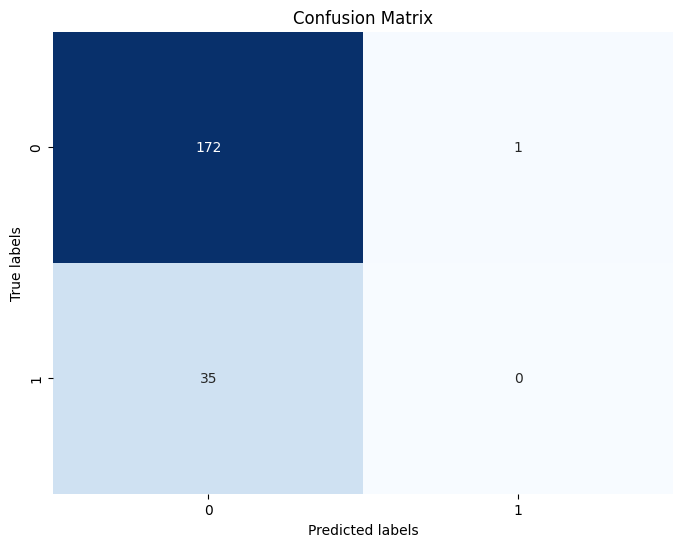

In [163]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Mapping Fact of Transfer by Demographic

In [192]:
for x in ['Black', 'Hispanic', 'Asian', 'White']:
  merged = bounds.merge(data[(data['tif_year'] == 2022) & (data['Majority Demographic'] == f'{x} Demographic Population')], on='tif_name', how='right')
  merged['transferred'] = merged['cumulative_transfers_in'] - merged['cumulative_transfers_out']
  merged['fact_of_transfer'] = np.where(merged['transferred'] == 0, 0,
                                          np.where(merged['transferred'] > 0, 1, -1))

  # Create a base layer for the interactive heatmap for census tracts
  fig = px.choropleth_mapbox(
      merged,
      geojson=merged.geometry,
      locations=merged.index,
      color='fact_of_transfer',  # Color based on population
      color_discrete_map={
          1: 'red',
          -1: 'blue',
          0: 'yellow'
      },
      # range_color=[0, 1],  # Set color range explicitly
      mapbox_style="carto-positron",
      center={"lat": merged.centroid.y.mean(), "lon": merged.centroid.x.mean()},
      zoom=10,
      opacity=0.5,
      labels={'tif_name'},
      hover_name='tif_name',  # Display community area name on hover
      title=f'{x} Demographic Population [Fact of Transfer]'
  )
  fig.update_layout(
    width=800,  # Set width to 800 pixels
    height=1000  # Set height to 600 pixels
  )
  fig.show()

  # Create a base layer for the interactive heatmap for census tracts
  fig = px.choropleth_mapbox(
      merged,
      geojson=merged.geometry,
      locations=merged.index,
      color='transferred',  # Color based on population
      color_continuous_scale=["blue", "red"],
      mapbox_style="carto-positron",
      center={"lat": merged.centroid.y.mean(), "lon": merged.centroid.x.mean()},
      zoom=10,
      opacity=0.5,
      labels={'tif_name'},
      hover_name='tif_name',  # Display community area name on hover
      title=f'{x} Demographic Population [Amount Transferred]'
  )
  fig.update_layout(
    width=800,  # Set width to 800 pixels
    height=1000  # Set height to 600 pixels
  )
  fig.show()

  print("Positive Transfer", len(merged[merged['fact_of_transfer']==1]))
  print("Negative Transfer", len(merged[merged['fact_of_transfer']==-1]))
  print("No Transfer", len(merged[merged['fact_of_transfer']==0]))

Output hidden; open in https://colab.research.google.com to view.